In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from scipy.stats import spearmanr
from scipy.signal import savgol_filter
from collections import Counter
from dtw import dtw
from numpy.linalg import norm
import scipy.stats

## Network sizes

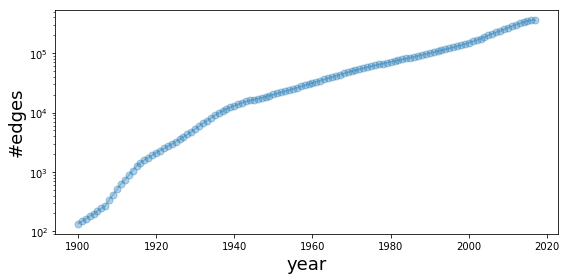

In [2]:
year, nodes, edges = zip(*[tuple([float(f) for f in line.strip().split('\t')])for line in open('networks/director_temporal_network_stats.dat')])

f, ax = plt.subplots(1,1,figsize = (8,4))
ax.plot(year, edges, 'o-', alpha = 0.35, markersize = 7, linewidth = 1.5)
ax.set_xlabel('year', fontsize = 18)
ax.set_ylabel('#edges', fontsize = 18)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('tempnwsize.png')


## DTW Comparison -- matching the network series to the impact series

Idea: the ups and downs in the impact are correlated with the network measures, however, those might be lagging in time. With DTW we drop the time dimension and match the two series maximizing correlation by inserting constant segments. 

- this way we will know which point (N') in the network measure series is the most likely to be associated to the highest impact (N*)

- there delay can tell us wheather the network measures peaked before or after the biggest hit, and what was that difference


QUESTION: SINCE WE ARE MATCHING TO GET HIGH CORRELATION, SHOULD WE SCALE THE VARIABLES TO HAVE THE SAME DISTRIBUTION, OR AT LEAST USE LOG IMPACT?

#### George Lucas as an example

[533664.0, 474520.0, 550248.0, 938781.0, 64801.0, 39894.0, 183.0, 45.0, 107.0, 86.0, 88.0]
-1.0 11.0 1.62377279682033 0.8495221891998682


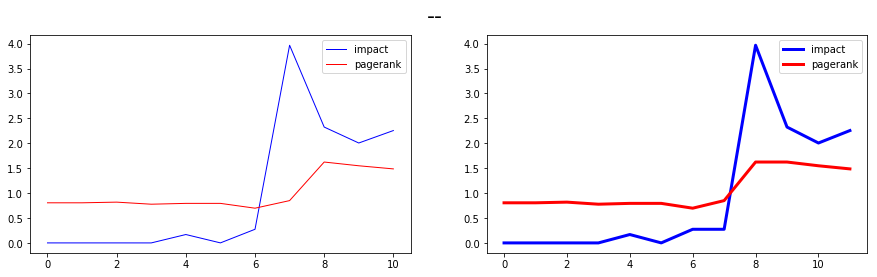

In [3]:
def get_data(idd):
    
    i = []
    p = []
    y = []

    for line in open('OLD/centrality-careers-old/centrality_careers_directors_QQ/'+idd+'_centrality_careers.dat'):
        name, movie, year, impact, betweenness, clustering, degree, pagerank = line.strip().split('\t')

        y.append(float(year))
        #i.append(math.log(float(impact)))
        
        i.append(float(impact))
        p.append(float(pagerank))


    return i, p, y
    

def deriv(x):
    
    xder = []
    
    for i in range(len(x)-1):
        xder.append(x[i+1] - x[i])

    return xder
        
        
def get_peak_diffs_null(x,y, year, title, derivatives, noviz = False):

    ''' WTF AM I DOING '''
    #  y -> impacs
    #  x -> nw meas
    #  which x ('s index) was matched to the max of y 
       
    
    avgi = np.mean(x)
    avgp = np.mean(y)
    
    x    = [ii / avgi for ii in x]
    y    = [pp / avgp for pp in y]    
    
    
    x, y, year = zip(*sorted([ (x[ijk], y[ijk], year[ijk]) for ijk in range(len(year)) ], key=lambda tup: tup[2])) 

    
        
    if derivatives:
        x = deriv(x)
        y = deriv(y)
        avgx = np.mean(x)
        avgy = np.mean(y)
        x = [xx / avgx for xx in x]
        y = [yy / avgy for yy in y]

       
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
  
    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    map_x, map_y = path
     
    if not noviz:       
        f, ax = plt.subplots(1,2, figsize = (15,4))
 
        ax[0].plot(x, 'b', linewidth = 1, label = 'impact')
        ax[0].plot(y, 'r', linewidth = 1, label = 'pagerank')

        ax[1].plot(x[map_x], 'b', linewidth = 3, label = 'impact')
        ax[1].plot(y[map_y], 'r', linewidth = 3, label = 'pagerank')

        [ax[i].legend(loc = 'best') for i in range(2)]
    
    
    maxI   = max(x)
    xmax_x = [i[0] for i in x[map_x]]
    ymax_y = [i[0] for i in y[map_y]]    
    y      = [i[0] for i in y]
    x      = [i[0] for i in x]
        
    maximpact_transformed_ind         = [ind for ind, I in enumerate(xmax_x) if I == maxI][0]
    maximpact_val_network_transformed = ymax_y[maximpact_transformed_ind]
        
    maxindex_nw   = y.index(maximpact_val_network_transformed)  #  N'
    maxindex_imp  = x.index(max(x))                             #  N*
    career_length = len(x)                                      #  N
    
    DELAY = maxindex_imp - maxindex_nw

    #plt.tight_layout()
    plt.suptitle(title, fontsize = 22)
    plt.savefig('career_' + title + '.png')
    
    return float(DELAY), float(career_length), maximpact_val_network_transformed, y[x.index(max(x))]


'''
nm0829038 12.0 11.616925055
nm0742341 2.0 11.7205573297
nm0000801 1.0 11.0631479028
nm0000770 1.0 10.6760233808
'''

i, p, y  = get_data('nm0000184')

print i

delta, N, nwmeas, nwmeas0 = get_peak_diffs_null(i, p, y, '--', derivatives = False) #
print delta, N, nwmeas, nwmeas0



## Parse career data

In [10]:
infolder = 'OLD/centrality-careers-old/centrality_careers_directors_QQ/'
files    = os.listdir(infolder)

In [11]:
long_careers   = {}
long_careers_R = {}
corrdata       = []


for ind, fn in enumerate(files):

    impacts = []
    betws   = []
    clusts  = []
    degs    = []
    prs     = []
    years   = []

    for line in open(infolder + '/' + fn):

        name, movie, year, impact, betweenness, clustering, degree, pagerank = line.strip().split('\t')

        if impact != 'None':

            impacts.append( math.log(float(impact) ) )
            betws.append( float( betweenness ) )
            degs.append( float( degree ) )
            prs.append( float( pagerank ) )
            years.append( float( year ) )
            

            
            
    if len(impacts) > 9 and float(year) < 2018:
        
        long_careers[name] = {}
        long_careers[name]['impacts'] =  impacts
        long_careers[name]['betws']   =  betws
        long_careers[name]['degs']    = degs
        long_careers[name]['prs']     = prs     
        long_careers[name]['years']   = years 
        
        
        maxI = max(impacts)
        
        for i in range(len(impacts)):
            if impacts[i] == maxI:
                corrdata.append((maxI, degs[i], prs[i]))
        
        
        impacts_R = list(impacts)
        betws_R   = list(betws)
        prs_R     = list(prs)
        
        random.shuffle(impacts_R)
        #random.shuffle(betws_R)
        random.shuffle(prs_R)
        
        long_careers_R[name] = {}
        long_careers_R[name]['impacts'] = impacts_R
        long_careers_R[name]['betws']   = betws_R
        long_careers_R[name]['degs']    = degs
        long_careers_R[name]['prs']     = prs_R     
        long_careers_R[name]['years']   = years  
        
        

print len(long_careers)

2394


0.09675845402506045
[[0.22832981]]


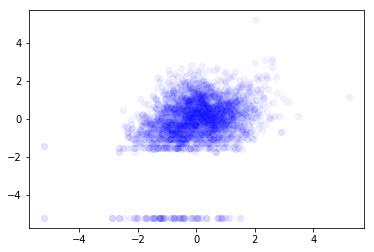

In [43]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

iii = [c[0] for c in corrdata] 
ddd = [c[1] for c in corrdata]
ppp = [c[2] for c in corrdata]

#plt.plot(, , 'bo', alpha = 0.1)
#plt.yscale('log')
#plt.xscale('log')

def rescale(vector): 
    v = StandardScaler().fit_transform(np.asarray(vector).reshape(-1, 1) ) 
    return preprocessing.quantile_transform(v, output_distribution = 'normal')


X1 = rescale(ppp)
X2 = rescale(ddd)
y  = rescale(iii)

plt.plot(y, X2, 'bo', alpha = 0.05)

reg = LinearRegression().fit(X2, y)
print reg.score(X2, y)
print reg.coef_

In [2]:
meas   = 'degs'
deltas = []
reld   = []

names_nwmeas  = {}
names_nwmeas0 = {}
names_Imax    = {}

for ind, (name, career) in enumerate(long_careers.items()):
    
    
    impact   = career['impacts']
    nwmeas   = career[meas]
    time     = career['years']
    
    #if max(impact) > 10:

    delta, N, nwmeass, nwmeass0 = get_peak_diffs_null(impact, nwmeas, time, 'a',False, noviz = True)

        #if delta > 0:
         #   print name, delta, max(impact)

    deltas.append(delta)
    reld.append(delta / N)

    names_nwmeas[name]  = max(impact)
    names_nwmeas0[name] = nwmeas[impact.index(max(impact))]
    names_Imax[name]    = max(impact) 

NameError: name 'long_careers' is not defined

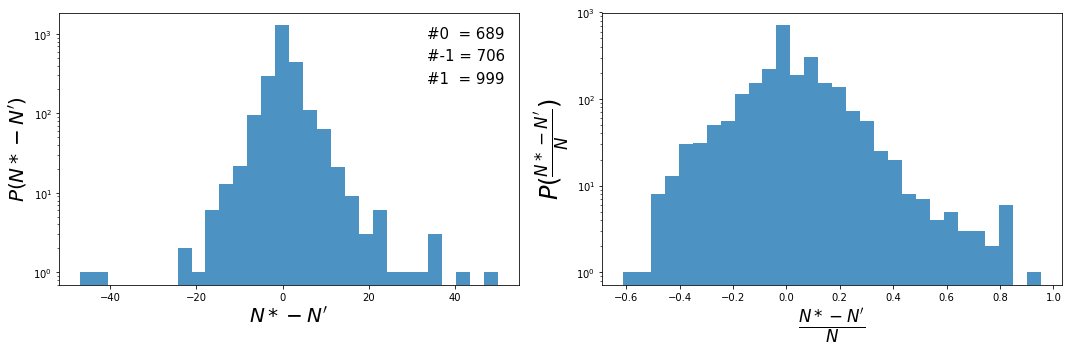

In [88]:
f, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(deltas, bins = 30, alpha = 0.8)
ax[0].set_yscale('log')
ax[0].set_xlabel('$N* - N\'$', fontsize = 20)
ax[0].set_ylabel('$P(N* - N\')$', fontsize = 20)

ax[1].hist(reld, bins = 30, alpha = 0.8)
ax[1].set_yscale('log')
ax[1].set_xlabel('$\\frac{N* - N\' }{N}$', fontsize = 24)
ax[1].set_ylabel('$P(\\frac{N* - N\' }{N})$', fontsize = 24)

deltas2 = [-1 if d < 0  else d for d in deltas]
deltas2 = [1  if d > 0 else d for d in deltas2]
count   = Counter(deltas2)


ax[0].plot([0],[0], label = '#0  = ' + str(count[0]) , linewidth = 0)
ax[0].plot([0],[0], label = '#-1 = ' + str(count[-1]), linewidth = 0)
ax[0].plot([0],[0], label = '#1  = ' + str(count[1]),  linewidth = 0)

ax[0].legend(loc = 'best', frameon = False, fontsize = 15)
plt.tight_layout()

## PREDICTIONS

Using the individuals delta and relativedelta parameters to predict
    - I*
    - Q
    
And compare the accuracy when we only use the network measure at N* to predict!

In [299]:
df            = pd.DataFrame()
df['names']   = names_nwmeas.keys()
df.index      = df.names
df            = df.drop(columns = ['names'])
df['nwmeas']  = names_nwmeas.values()
df['nwmeas0'] = [names_nwmeas0[k] for k in names_nwmeas.keys()] 
df['Imax']    = [names_Imax[k] for k in names_nwmeas.keys()] 

df

,nwmeas,nwmeas0,Imax
names,,,
nm0336139,6.688355,98.0,6.688355
nm0302323,5.093750,10.0,5.093750
nm0107854,6.848005,7.0,6.848005
nm0068691,5.826000,95.0,5.826000
nm0001219,11.350571,74.0,11.350571
nm0441914,8.801620,26.0,8.801620
nm0001214,11.464449,4.0,11.464449
nm0085865,7.050123,6.0,7.050123
nm0005738,10.157587,49.0,10.157587


0.08380499938653319
[[0.2130815]]


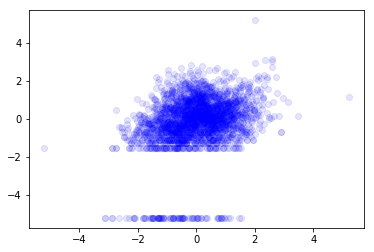

In [320]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


def rescale(vector):
    
    v = StandardScaler().fit_transform(np.asarray(vector).reshape(-1, 1) ) 
    return preprocessing.quantile_transform(v, output_distribution = 'normal')

y    = df['Imax']
df2  = df.drop(columns = ['Imax'])

X1 = rescale(df2['nwmeas'])
X2 = rescale(df2['nwmeas0'])
y  = rescale(y)


plt.plot(y, X2, 'bo', alpha = 0.1)

reg = LinearRegression().fit(X2, y)
print reg.score(X2, y)
print reg.coef_

## Study correlations between nw measure and impact time series

/usr/local/lib/python2.7/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


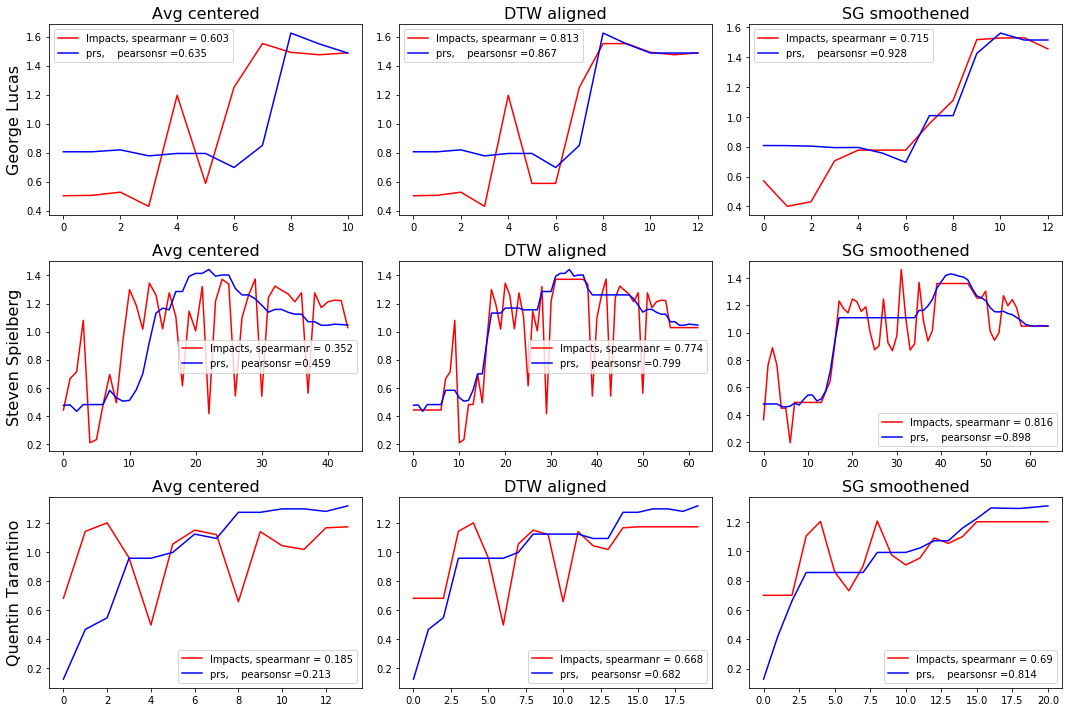

In [12]:
def get_correls(x, y):
    
    return str(round(scipy.stats.pearsonr(x,y)[0], 3)), str(round(scipy.stats.spearmanr(x, y)[0], 3)), str(round(scipy.stats.kendalltau(x, y)[0], 3))    


def get_correl_plot(long_careers, name, title, meas, ax):

    x     = long_careers[name]['impacts']
    y     = long_careers[name][meas]
    years = long_careers[name]['years']
    
    
    x, y, years = zip(*sorted([ (x[i], y[i], years[i]) for i in range(len(years)) ], key=lambda tup: tup[2])) 
    #CP, CS, SK  = get_correls(x, y)
    #ax[0].plot(x, color = 'r', label = 'Impacts, spearmanr = ' + CS)  
    #ax[0].plot(y, color = 'b', label = 'Betws,    pearsonsr =' + CP)  
    #ax[0].set_title('Raw', fontsize = 16)                 


    x = [xx/np.mean(x) for xx in x]
    y = [xx/np.mean(y) for xx in y]
    CP, CS, SK = get_correls(x, y)
    labeldata = '\ncorrelations: pears = ' + CP + ', spear = ' + CS #+ ', ken = ' + SK
    ax[0].plot(x, color = 'r', label = 'Impacts, spearmanr = ' + CS)
    ax[0].plot(y, color = 'b', label = meas + ',    pearsonsr ='  + CP)  
    ax[0].set_title('Avg centered' , fontsize = 16)  

    
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    map_x, map_y = path
    CP, CS, SK = get_correls(x[map_x], y[map_y])
    ax[1].plot(x[map_x], color = 'r', label = 'Impacts, spearmanr = ' + CS)  
    ax[1].plot(y[map_y], color = 'b', label = meas + ',    pearsonsr =' + CP)  
    ax[1].set_title('DTW aligned', fontsize = 16)  

    
    x     = long_careers[name]['impacts']
    y     = long_careers[name][meas]
    years = long_careers[name]['years']
    x, y, years = zip(*sorted([ (x[i], y[i], years[i]) for i in range(len(years)) ], key=lambda tup: tup[2])) 
    x = [xx/np.mean(x) for xx in x]
    y = [xx/np.mean(y) for xx in y]
    
    x = savgol_filter(x, 5, 2)   
    y = savgol_filter(y, 5, 2)       
    
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    map_x, map_y = path
    CP, CS, SK = get_correls(x[map_x], y[map_y])
    ax[2].plot(x[map_x], color = 'r', label = 'Impacts, spearmanr = ' + CS)  
    ax[2].plot(y[map_y], color = 'b', label = meas + ',    pearsonsr =' + CP)  
    ax[2].set_title('SG smoothened', fontsize = 16)    
    
    [ax[i].legend(loc = 'best') for i in range(3)]
    
    ax[0].set_ylabel(title, fontsize = 16)
    plt.tight_layout()


f, ax = plt.subplots(3,3, figsize = (15,10))  

meas = 'prs'

get_correl_plot(long_careers, 'nm0000184', 'George Lucas',      meas,  [ax[0,0], ax[0,1], ax[0,2]])
get_correl_plot(long_careers, 'nm0000229', 'Steven Spielberg',  meas,  [ax[1,0], ax[1,1], ax[1,2]])
get_correl_plot(long_careers, 'nm0000233', 'Quentin Tarantino', meas,  [ax[2,0], ax[2,1], ax[2,2]])

folderout = 'NetworkFigs/'
if not os.path.exists(folderout):
    os.makedirs(folderout)

plt.savefig(folderout + 'career_examples_nw_measures_' + meas + '_log.png')
plt.savefig('4_QQnetwork_logimpacts.png')

/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


nan


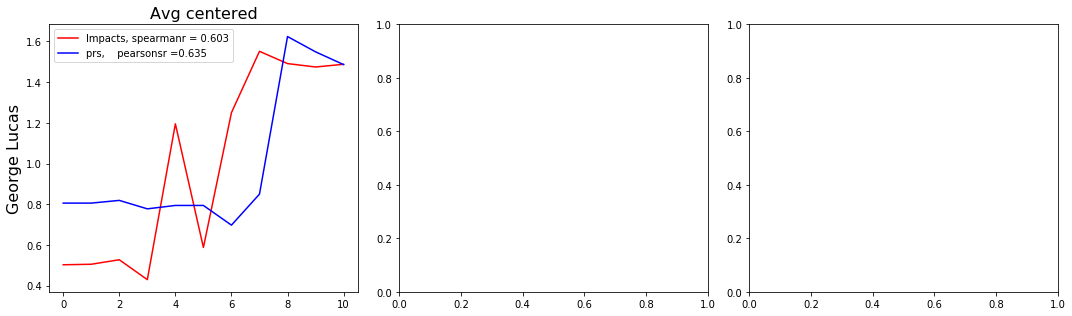

In [17]:
def get_correls(x, y):
    
    return str(round(scipy.stats.pearsonr(x,y)[0], 3)), str(round(scipy.stats.spearmanr(x, y)[0], 3)), str(round(scipy.stats.kendalltau(x, y)[0], 3))    


def get_beatuy_correl_plot(long_careers, name, title, meas, ax):

    x     = long_careers[name]['impacts']
    y     = long_careers[name][meas]
    years = long_careers[name]['years']
    
    
    x, y, years = zip(*sorted([ (x[i], y[i], years[i]) for i in range(len(years)) ], key=lambda tup: tup[2])) 
  

    x = [xx/np.mean(x) for xx in x]
    y = [xx/np.mean(y) for xx in y]
    CP, CS, SK = get_correls(x, y)
    labeldata = '\ncorrelations: pears = ' + CP + ', spear = ' + CS #+ ', ken = ' + SK
    
    t0 = 0.0
    c0 = x[0]
    t2 = float(len(x))
    B  = 0.0

    
    for tm, cm in enumerate(x):
    
        t  = t2 - tm
        lm = (cm - c0) / (tm - t0) * t + c0 - cm
        
        
        B += lm
        
    print B    
        
    ax.plot(x, color = 'r', label = 'Impacts, spearmanr = ' + CS)
    ax.plot(y, color = 'b', label = meas + ',    pearsonsr ='  + CP)  
    ax.set_title('Avg centered' , fontsize = 16)  

    
    ax.legend(loc = 'best')
    
    ax.set_ylabel(title, fontsize = 16)
    plt.tight_layout()


f, ax = plt.subplots(1,3, figsize = (15,4.5))  

meas = 'prs'

get_beatuy_correl_plot(long_careers, 'nm0000184', 'George Lucas',      meas,  ax[0])
#get_beatuy_correl_plot(long_careers, 'nm0000229', 'Steven Spielberg',  meas,  ax[1])
#get_beatuy_correl_plot(long_careers, 'nm0000233', 'Quentin Tarantino', meas,  ax[2])



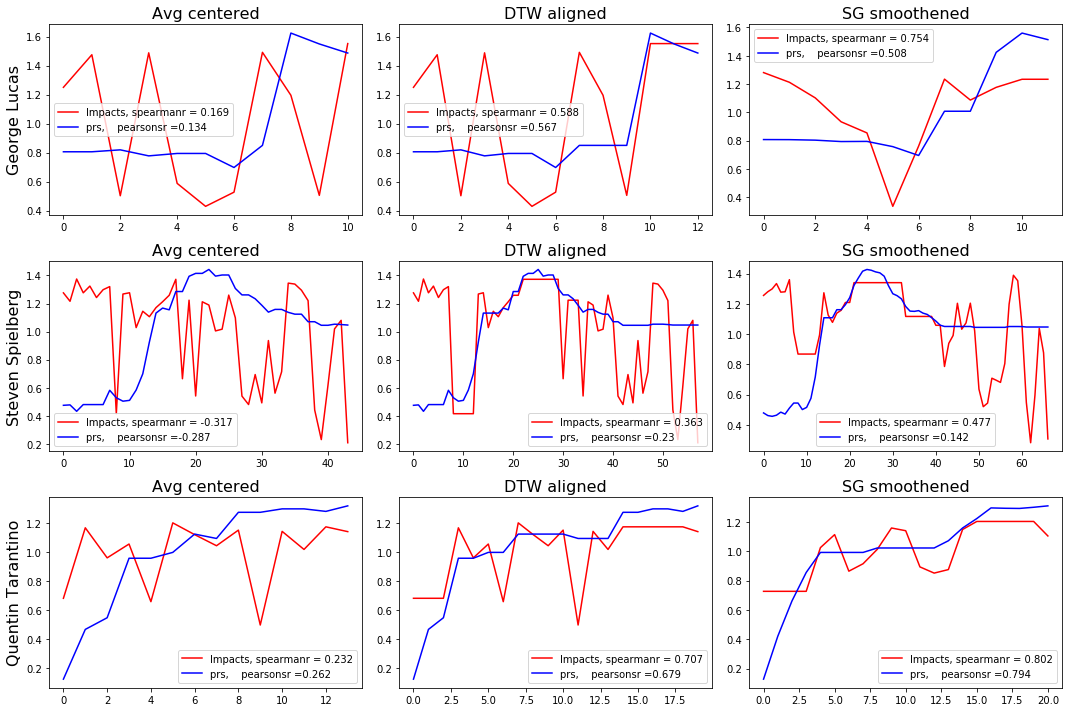

In [98]:
# RANDOMIZED CAREERS

f, ax = plt.subplots(3,3, figsize = (15,10))  

meas = 'prs'

get_correl_plot(long_careers_R, 'nm0000184', 'George Lucas',      meas,  [ax[0,0], ax[0,1], ax[0,2]])
get_correl_plot(long_careers_R, 'nm0000229', 'Steven Spielberg',  meas,  [ax[1,0], ax[1,1], ax[1,2]])
get_correl_plot(long_careers_R, 'nm0000233', 'Quentin Tarantino', meas,  [ax[2,0], ax[2,1], ax[2,2]])

folderout = 'NetworkFigs/'
if not os.path.exists(folderout):
    os.makedirs(folderout)

plt.savefig(folderout + 'career_examples_nw_measures_' + meas + '_log.png')

In [123]:
def get_correls(x, y):
    
    return float(scipy.stats.pearsonr(x,y)[0]), float(scipy.stats.spearmanr(x, y)[0])


def get_correl_data(data,  meas):

    x     = data['impacts']
    y     = data[meas]
    years = data['years']

    x, y, years = zip(*sorted([ (x[i], y[i], years[i]) for i in range(len(years)) ], key=lambda tup: tup[2])) 

    x = [xx/np.mean(x) for xx in x]
    y = [xx/np.mean(y) for xx in y]
    CP_raw, CS_raw = get_correls(x, y)
 
    
    
    
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    map_x, map_y = path
    CP_dtw, CS_dtw = get_correls(x[map_x], y[map_y])
     

    x     = data['impacts']
    y     = data[meas]
    years = data['years']
    x, y, years = zip(*sorted([ (x[i], y[i], years[i]) for i in range(len(years)) ], key=lambda tup: tup[2])) 
    x = [xx/np.mean(x) for xx in x]
    y = [xx/np.mean(y) for xx in y]
    x = savgol_filter(x, 5, 2)   
    y = savgol_filter(y, 5, 2)       
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    map_x, map_y = path
    CP_sg, CS_sg = get_correls(x[map_x], y[map_y])

    return CP_raw, CS_raw, CP_dtw, CS_dtw, CP_sg, CS_sg





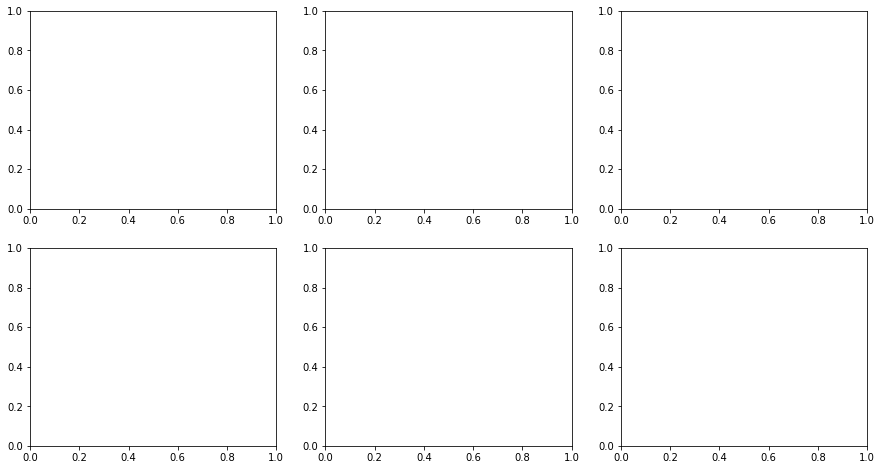

In [126]:
def plot_hist(ax, data, xlabel, color, label):

    ax.set_xlabel(xlabel, fontsize = 12)
    data = [x for x in data if str(x) != 'nan']
    y, x, _ = ax.hist(data, bins = 30, alpha = 0.5, color = color, label = label)
    ax.set_xlim([-1.0,1.0])
    ax.legend(loc = 'best', fontsize = 11)




def get_histograms(career_dict, ax, color, meas, label_):

    CP_raws = []
    CS_raws = []
    CP_dtws = []
    CS_dtws = []
    CP_sgs  = []
    CS_sgs  = []

    for ind, (name, data) in enumerate(career_dict.items()):
    
        i#f ind == 100: break        
        try:
            CP_raw, CS_raw, CP_dtw, CS_dtw, CP_sg, CS_sg = get_correl_data(data,   meas)

            CP_raws.append( CP_raw )
            CS_raws.append( CS_raw )
            CP_dtws.append( CP_dtw )
            CS_dtws.append( CS_dtw ) 
            CP_sgs.append(  CP_sg ) 
            CS_sgs.append(  CS_sg ) 

        except:
            pass

    plot_hist(ax[0,0], CP_raws, 'perasonr,  raw', color = color, label = label_)
    plot_hist(ax[1,0], CS_raws, 'spearmanr, raw', color = color, label = label_)

    plot_hist(ax[0,1], CP_dtws, 'perasonr,  dtw', color = color, label = label_)
    plot_hist(ax[1,1], CS_dtws, 'spearmanr, dtw', color = color, label = label_)

    plot_hist(ax[0,2], CP_sgs, 'perasonr,  sg', color = color, label = label_)
    plot_hist(ax[1,2], CS_sgs, 'spearmanr, sg', color = color, label = label_)

    plt.suptitle(meas, fontsize = 17)
    plt.savefig(folderout + 'correlation_hist_' + meas + '.png')  
    
    
f, ax = plt.subplots(2,3, figsize = (15,8))  
#get_histograms(long_careers_R, ax, 'darkred', 'betws')
#get_histograms(long_careers, ax, 'steelblue', 'betws')



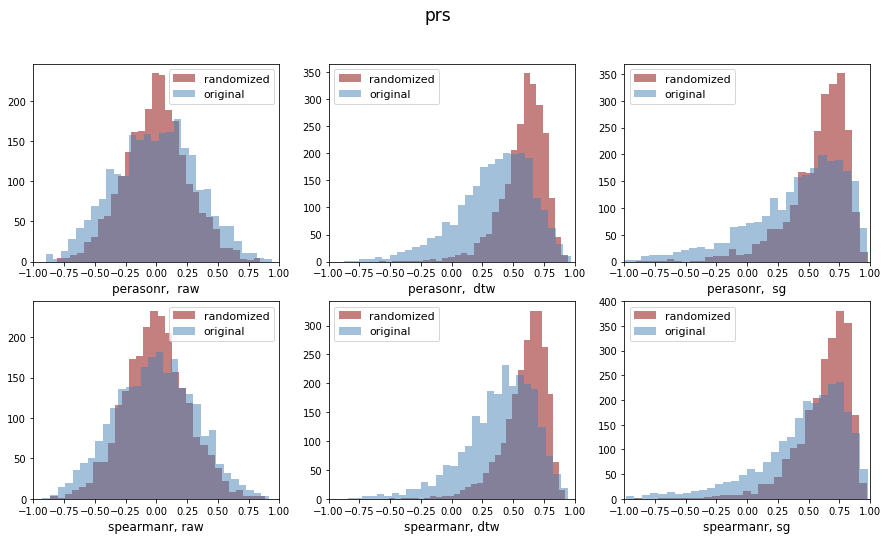

In [129]:
f, ax = plt.subplots(2,3, figsize = (15,8))  
get_histograms(long_careers_R, ax, 'darkred', 'prs', 'randomized')
get_histograms(long_careers, ax, 'steelblue', 'prs', 'original')